# Project Title

**Authors:** Anita Camlic, Eddie Juarez, Dermot O'Brien
***

## Overview

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Overview

### Data Dictionary

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `sex`: Sex
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: children", "Govt_job", "Never_worked", "Private" or "Self-employed"
- ` Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke or 0 if not

**Note:** "Unknown" in smoking_status means that the information is unavailable for this patient

## Data Understanding

In this section, we are going to explore the dataset with summary statistics and then take a deeper dive into the variables with some visualizations
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

### Import Data and Create Dataframes

In [2]:
# Import Standard Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
%matplotlib inline

In [3]:
# Import the data
df = pd.read_csv('./Data/stroke.csv')

### Exploratory Data Analysis

In [4]:
# Check rows and columns
df.shape

(5110, 12)

In [5]:
# See what the data looks like
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
# Check descriptive statistics
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
# Check BMI data
df.bmi.sort_values(ascending=False).head(30)

2128    97.6
4209    92.0
928     78.0
544     71.9
1559    66.8
358     64.8
4188    64.4
2764    63.3
3825    61.6
2840    61.2
270     60.9
4838    60.9
466     60.2
3588    59.7
3060    58.1
4351    57.9
1898    57.7
715     57.5
1595    57.3
4475    57.2
4154    57.2
113     56.6
4952    56.6
2081    56.1
1660    56.0
1584    55.9
4225    55.9
4407    55.7
672     55.7
662     55.7
Name: bmi, dtype: float64

**Drop BMI's above 90**

In [8]:
# Check for NaN's
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
# Check the value counts of the stroke column
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [10]:
# Check the percentage distribution of the stroke column
df.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [11]:
# Check gender value counts
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
# Check the stroke rates of males and females
df[['gender', 'stroke']].groupby('gender', as_index=False).mean().sort_values(by='stroke', ascending=False)

,gender,stroke
1,Male,0.051064
0,Female,0.047094
2,Other,0.000000


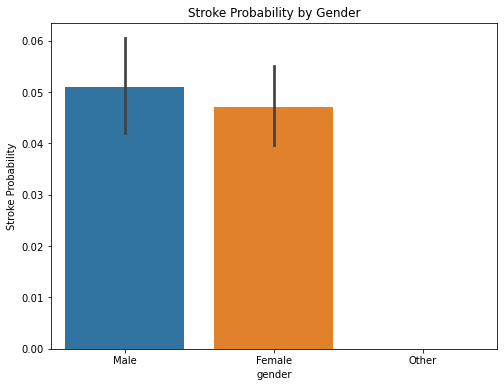

In [13]:
# Create a barplot showing the Stroke Probabilities of males and females
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='gender', y='stroke', data=df)
ax.set_ylabel('Stroke Probability')
ax.set_title('Stroke Probability by Gender');

**Drop row with gender = 'other'**

In [14]:
# Check age column
df.age.sort_values().head(50)

3295    0.08
1614    0.08
3618    0.16
4021    0.16
3968    0.16
3392    0.24
996     0.24
2898    0.24
4293    0.24
1999    0.24
2579    0.32
564     0.32
3859    0.32
4910    0.32
1093    0.32
4581    0.40
1600    0.40
4645    0.48
4053    0.48
2030    0.48
3251    0.56
1975    0.56
2008    0.56
3894    0.56
3440    0.56
1808    0.64
2012    0.64
363     0.64
2875    0.64
4409    0.72
4929    0.72
4007    0.72
1206    0.72
5089    0.72
2801    0.80
2630    0.80
1317    0.80
3626    0.80
2490    0.88
376     0.88
2358    0.88
2481    0.88
982     0.88
951     1.00
2240    1.00
1794    1.00
1432    1.00
844     1.00
1366    1.08
2305    1.08
Name: age, dtype: float64

In [15]:
# Check age for stroke victims
df.loc[df['stroke'] == True]['age'].sort_values()

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
       ...  
42     82.00
56     82.00
188    82.00
23     82.00
35     82.00
Name: age, Length: 249, dtype: float64

In [16]:
# Check BMI Nulls
df.bmi.isna().sum()

201

In [17]:
# Check BMI
df.loc[df['bmi'].isnull()]['stroke'].value_counts(normalize=True) 

0    0.800995
1    0.199005
Name: stroke, dtype: float64

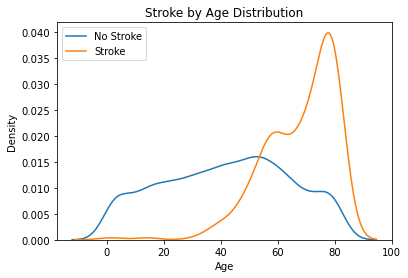

In [18]:
# Create a KDE Plot that shows the survival of passengers according to their age
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke')
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke')
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

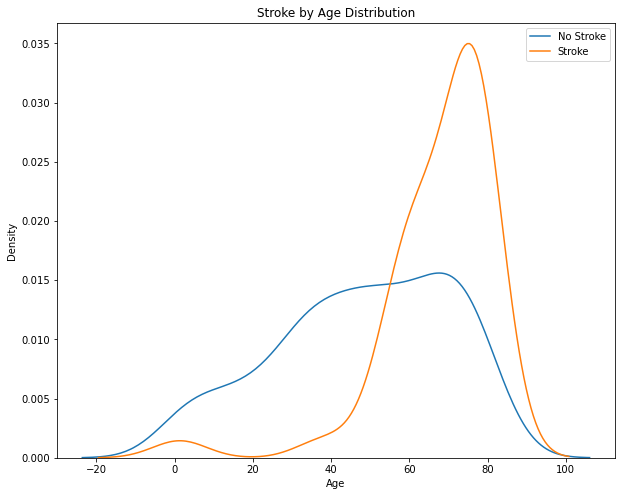

In [19]:
# Create a KDE Plot that shows the survival of passengers according to their age
sns.kdeplot(df['age'][df['stroke'] == 0][df['bmi'].isnull()], label='No Stroke')
sns.kdeplot(df['age'][df['stroke'] == 1][df['bmi'].isnull()], label='Stroke')
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

In [20]:
df['hypertension'].value_counts(normalize=True)

0    0.902544
1    0.097456
Name: hypertension, dtype: float64

In [21]:
# Check Null BMI vs Hypertension
df.loc[df['bmi'].isnull()]['hypertension'].value_counts(normalize=True)

0    0.766169
1    0.233831
Name: hypertension, dtype: float64

In [22]:
df['heart_disease'].value_counts(normalize=True)

0    0.945988
1    0.054012
Name: heart_disease, dtype: float64

In [23]:
# Check Null BMI vs Hypertension
df.loc[df['bmi'].isnull()]['heart_disease'].value_counts(normalize=True)

0    0.835821
1    0.164179
Name: heart_disease, dtype: float64

In [24]:
# Check Null BMI vs glucose level
df.loc[df['bmi'].isnull()]['avg_glucose_level'].value_counts(normalize=True)

88.27     0.009950
101.45    0.009950
73.02     0.004975
108.62    0.004975
87.80     0.004975
            ...   
216.88    0.004975
214.77    0.004975
92.97     0.004975
111.98    0.004975
237.75    0.004975
Name: avg_glucose_level, Length: 199, dtype: float64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [25]:
# Drop row with gender = 'other'
df = df[df.gender != 'Other']

In [26]:
# Drop ID column
df.drop(labels='id', axis=1, inplace=True)

In [27]:
# Create a new column that flags missing bmi values
df['indicator'] = 0
df.loc[df['bmi'].isnull(),'indicator'] = 1

In [28]:
# Impute missing bmi values based on median
bmi_median = df['bmi'].median()

df.fillna(bmi_median, inplace=True)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Class Setup for Model Evaluation

In [35]:
# Create a Class to evaluate each model with cross validation

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # wut
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Dummy Model

In [30]:
# Create variables and split data into training and testing
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
# Dummy Model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

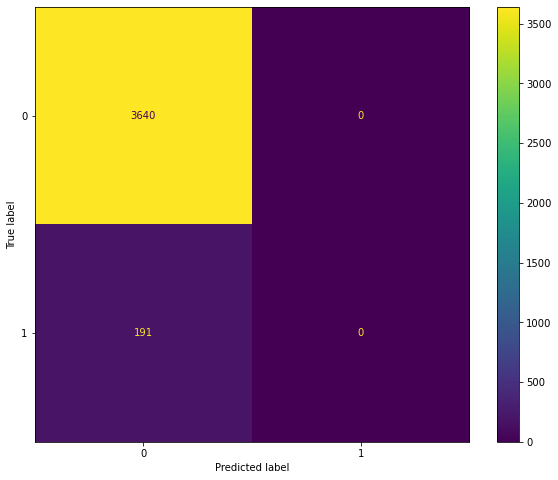

In [32]:
# Plot a confusion matrix for our dummy model
plot_confusion_matrix(dummy_model, X_train, y_train);

In [38]:
# Evaluate model with CV
dummy_results = ModelWithCV(model=dummy_model,
                         model_name='dummy_results',
                         X=X_train,
                         y=y_train)

dummy_results.print_cv_summary()

CV Results for `dummy_results` model:
             0.95014 accuracy
             0.00000 recall
             0.00000 precision
        


/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Pipeline Setup

In [39]:
# Create pipelines for numeric and categorical to fit into Categorical Transformer.

num_pipeline = Pipeline(steps=[('num_impute', SimpleImputer(add_indicator=True, strategy='median')),
                           ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [40]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.

CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, ['age', 'avg_glucose_level', 'bmi']),
                                         ('cat_pipeline', cat_pipeline, ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'indicator'])],
                           remainder='passthrough')

### Logistic Regression

In [61]:
# Create a logistic regression model using created pipeline
logreg_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression())])
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                     

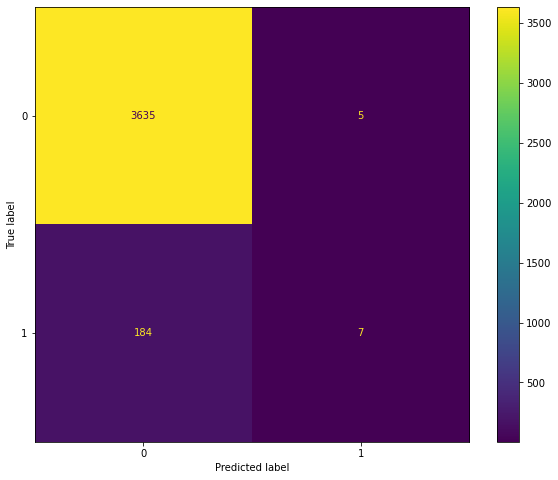

In [62]:
# Plot a confusion matrix for our Log reg model
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [63]:
# Evaluate model with CV
logreg_results = ModelWithCV(model=logreg_pipe,
                         model_name='logreg_pipe',
                         X=X_train,
                         y=y_train)

logreg_results.print_cv_summary()

/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Results for `logreg_pipe` model:
             0.94936 accuracy
             0.02579 recall
             0.26667 precision
        


/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Trees

In [64]:
# Create a decision tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                            ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                     

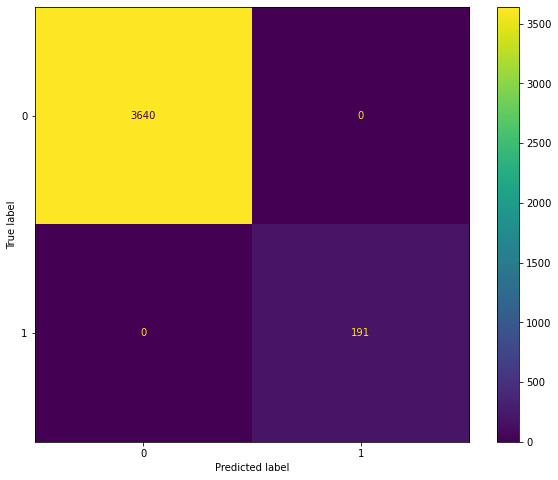

In [65]:
# Plot confusion matrix
plot_confusion_matrix(dtree_pipe, X_train, y_train);

In [66]:
# Evaluate model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary()

CV Results for `dtree_pipe` model:
             0.91021 accuracy
             0.21447 recall
             0.17418 precision
        


**above is incorrect**

### KNN

In [49]:
# Create a knn model using created pipeline
knn_pipe = Pipeline(steps=[('ct', CT),
                            ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                     

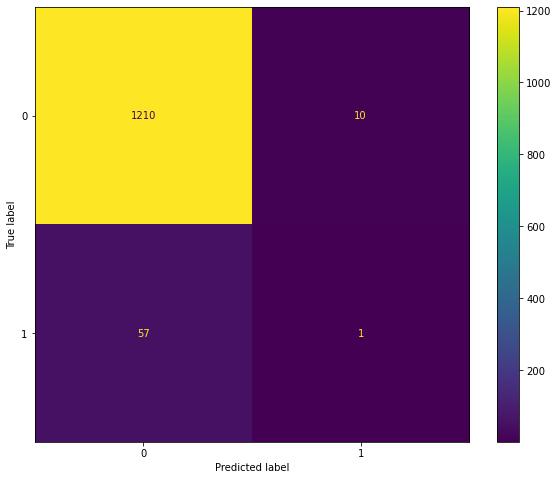

In [50]:
# Plot confusion matrix
plot_confusion_matrix(knn_pipe, X_test, y_test);

In [51]:
# Evaluate model with CV
knn_results = ModelWithCV(model=knn_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

knn_results.print_cv_summary()

/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Results for `knn_results` model:
             0.94727 accuracy
             0.02105 recall
             0.13333 precision
        


### Random Forest

In [52]:
# Create a knn model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                            ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                     

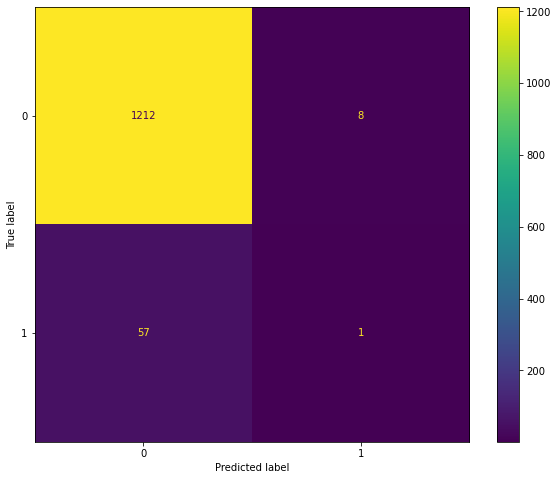

In [53]:
# Plot confusion matrix
plot_confusion_matrix(rfc_pipe, X_test, y_test);

In [57]:
# Evaluate model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary()

CV Results for `rfc_pipe` model:
             0.95040 accuracy
             0.05737 recall
             0.48833 precision
        


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***